## Bob Graham Round predictions 
### Intro
This script attempts to predict a Bob Graham round finishing time based on the race results of other finishers. The membership list of the BGR is imported into the DUV ultramarathon databased to obtain runner ID's. The each race result is then scraped from the DUV site and the results of any of the Bob Graham finishers are then stored. 

The idea is then to input a specific race result that you've completed or specific distance stats to see where you compare to other finishers. Or possibly to use machine learning to predict finish times.

Time improvements can be made by scraping in parallel 

### Load data

In [10]:
import requests
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

import pandas as pd

In [139]:
# Load the finishers from the Bob Graham website
CSV_URL = "http://bobgrahamclub.org.uk/api/data_bgr_listing.csv"

bg_results = pd.read_csv(CSV_URL)
bg_results['time seconds'] = pd.to_timedelta(bg_results['time'] + ':00')
bg_results['time seconds'] = bg_results['time seconds'].dt.total_seconds()
print(bg_results.head()) 

        gn        fn gender  age   time        date  weekNum dir  mem  orig  \
0     Alan    Heaton      M   32  22:18  1960-06-26       25   A    1     0   
1  Stanley  Bradshaw      M   48  23:25  1960-07-09       27   C    2     0   
2  Kenneth    Heaton      M   35  22:13  1961-06-24       25   C    3     0   
3     Eric     Beard      M   31  23:35  1963-07-06       27   C    4     0   
4     Joss    Naylor      M   34  23:37  1971-06-26       25   C    5     0   

   ...  record  lr  died  nationality                       club prev  \
0  ...       1   0  2019      British  Clayton-le-Moors Harriers    0   
1  ...       0   0  2010      British  Clayton-le-Moors Harriers    1   
2  ...       1   0  2014      British  Clayton-le-Moors Harriers    0   
3  ...       0   0  1969      British        Leeds Athletic Club    0   
4  ...       0   0     0      British       Kendal Athletic Club    0   

  postcode                                              notes reg_gap  \
0       S8  (

In [2]:
# Load DUV bulk search from https://statistik.d-u-v.org/bulk_search.php
DUV_PATH = "./data/DUV_Bulkexport_20240416.xls"

# Results get exported as html rather than xls
def load_html_to_dataframe(file_path):
    try:
        dfs = pd.read_html(file_path, encoding='utf-8')
        return dfs
    except Exception as e:
        print(f"Failed to load the HTML file: {e}")
        return None

duv_runners = load_html_to_dataframe(DUV_PATH)
if duv_runners:
    for i, df in enumerate(duv_runners):
        print(f"Table {i+1}:")
        print(df.head())  # Display the first few rows of each DataFrame

Table 1:
  Unnamed: 0_level_0 DUV Ultra Marathon Statistics                       \
             Counter                       Surname First name Runner ID   
0                  1                        Heaton       Alan   1462093   
1                  2                      Bradshaw    Stanley    Search   
2                  3                        Heaton    Kenneth    Search   
3                  4                         Beard       Eric   1048701   
4                  5                        Naylor       Joss    Search   

                                                                
  Original name Nat.  M/F     YOB Date of birth Cat. internat.  
0           NaN  GBR    M     NaN    00.00.0000            NaN  
1           NaN  NaN  NaN     NaN           NaN            NaN  
2           NaN  NaN  NaN     NaN           NaN            NaN  
3           NaN  GBR    M  1931.0    00.00.0000            NaN  
4           NaN  NaN  NaN     NaN           NaN            NaN  


In [3]:
# DF of runners found by name in DUV bulk search
valid_runners = df[df[('DUV Ultra Marathon Statistics', 'Runner ID')] != 'Search']
valid_runners.columns = valid_runners.columns.droplevel(0)
valid_runners.head()

,Counter,Surname,First name,Runner ID,Original name,Nat.,M/F,YOB,Date of birth,Cat. internat.
0,1,Heaton,Alan,1462093,NaN,GBR,M,NaN,00.00.0000,NaN
3,4,Beard,Eric,1048701,NaN,GBR,M,1931.0,00.00.0000,NaN
6,7,Talbot,Donald,482320,NaN,GBR,M,1932.0,00.00.0000,NaN
12,13,Weir,Dennis,113489,NaN,GBR,M,1938.0,25.03.1938,M85
13,14,Millen,Boyd,1051631,NaN,GBR,M,1936.0,25.01.1936,M85


In [141]:
bg_results.rename(columns={'gn': 'First name', 'fn': 'Surname'}, inplace=True)

# Merging the data on 'First name' and 'Surname'
merged_df = pd.merge(valid_runners, bg_results, on=['First name', 'Surname']).drop_duplicates()

merged_df.head()

#merged_df.to_csv('tmp_bgr.csv', index=False)

Functions for scraping DUV results

In [115]:
def fetch_html(url):
    """Fetch the content of a URL with retries and backoff."""
    session = requests.Session()
    # Setup retry strategy
    retries = Retry(
        total=5,  # Total retries
        backoff_factor=1,  # Time between retries, exponential backoff factor
        status_forcelist=[500, 502, 503, 504, 429],  # Retry on these status codes
    )
    # Mount it for both http and https connections
    session.mount('http://', HTTPAdapter(max_retries=retries))
    session.mount('https://', HTTPAdapter(max_retries=retries))

    try:
        response = session.get(url, timeout=10)  # 10 seconds timeout for the request
        if response.ok:
            return BeautifulSoup(response.content, 'html.parser')
        else:
            response.raise_for_status()  # This will raise an error for 4XX client errors
    except requests.RequestException as e:
        print(f"Error fetching the URL {url}: {e}")
        return None

def extract_page_count(soup):
    """Extract the number of pages from the pagination element."""
    pagination = soup.find('div', class_='pagination')
    return int(pagination.find_all('a')[-2].text) if pagination else 1

def extract_event_links(base_url, soup):
    """ Extract event links from the page. """
    links = []
    for link in soup.find_all('a', href=True):
        href = link['href']
        if 'getresultevent.php?event=' in href:
            links.append(base_url + href)
    return links

def extract_event_details(soup):
    """Extract 'Event', 'Date', 'Finishers' and 'Distance' from the HTML content."""
    details = {}
    try:
        info_rows = soup.find_all('tr')  # Find all table rows in the page
        for row in info_rows:
            # Look for rows where the first cell contains the labels we're interested in
            header_cell = row.find('td')
            if header_cell and header_cell.find('b'):  # Check for bold tags which might contain labels
                label = header_cell.get_text(strip=True).rstrip(':')
                value_cell = header_cell.find_next_sibling('td')  # Get the next sibling cell for the value
                if label in ['Date', 'Event', 'Distance', 'Finishers'] and value_cell:
                    details[label] = value_cell.get_text(strip=True)
    except Exception as e:
        print(f"Error extracting event details: {e}")
    return details


def fetch_event_data(table_soup, event_details):
    """Extract data and runner IDs from the event table, including event details."""
    data = []
    headers = [th.text.strip() for th in table_soup.find_all('th')]
    # Append the event details headers
    headers.extend(['Runner ID', 'Event', 'Date', 'Distance', 'Finishers'])

    rows = table_soup.find_all('tr')[1:]  # Skip the header row
    for row in rows:
        cols = row.find_all('td')
        row_data = [col.text.strip() for col in cols]
        # Get runner ID
        link = cols[2].find('a', href=True)  # Assuming the third column has the link
        runner_id = link['href'].split('runner=')[-1] if link else 'No ID'
        # Include event details and runner ID
        row_data.extend([runner_id, event_details['Event'], event_details['Date'], event_details['Distance'], event_details['Finishers']])
        data.append(row_data)

    return pd.DataFrame(data, columns=headers)

def fetch_event_data(table_soup, event_details, valid_ids):
    """Extract data and runner IDs from the event table, appending event details, filtered by valid runner IDs."""
    data = []
    headers = [th.text.strip() for th in table_soup.find_all('th')]
    headers.extend(['Runner ID', 'Event', 'Date', 'Distance', 'Finishers'])
    rows = table_soup.find_all('tr')[1:]  # Skip header row
    
    for row in rows:
        cols = row.find_all('td')
        if len(cols) > 2:
            link = cols[2].find('a', href=True)
            if link and 'runner=' in link['href']:
                runner_id = link['href'].split('runner=')[-1]
                # Only add data if runner_id is in the list of valid_ids
                if runner_id in valid_ids:
                    row_data = [col.text.strip() for col in cols]
                    row_data.extend([runner_id, event_details.get('Event', 'N/A'), event_details.get('Date', 'N/A'), event_details.get('Distance', 'N/A'), event_details.get('Finishers', 'N/A')])
                    data.append(row_data)
    
    return pd.DataFrame(data, columns=headers)

def scrape_events(base_url, event_url):
    """Scrape events with additional details."""
    soup = fetch_html(base_url + event_url)
    event_details = extract_event_details(soup)
    table_soup = soup.find('table', {'id': 'Resultlist'})
    if table_soup:
        return fetch_event_data(table_soup, event_details)
    return pd.DataFrame()

def extract_specific_links(soup, base_url, path_starts_with):
    """Extract specific links that start with a given path from the parsed HTML."""
    links = []
    if soup:
        # Find all 'a' tags with an 'href' attribute
        for a in soup.find_all('a', href=True):
            href = a['href']
            # Check if the href starts with the desired path
            if href.startswith(path_starts_with):
                full_link = base_url + href
                links.append(full_link)
    return links

# URL configuration
base_url = "https://statistik.d-u-v.org/"
#event_url = "getresultevent.php?event=102988"

# Perform the scraping
#event_data = scrape_events(base_url, event_url)

# Display or export the data
# print(event_data)


In [112]:
def main():
    base_url = "https://statistik.d-u-v.org/"
    start_year = 2019
    end_year = 2019  # Adjust as needed
    valid_ids = set(valid_runners["Runner ID"])

    for year in range(start_year, end_year + 1):
        page_url = f"{base_url}geteventlist.php?year={year}&dist=all&country=all&surface=all&sort=1&page=1"
        first_page = fetch_html(page_url)
        if first_page:
            num_pages = extract_page_count(first_page)
            all_data = []

            for page in range(1, num_pages + 1):
                page_url = f"{base_url}geteventlist.php?year={year}&dist=all&country=all&surface=all&sort=1&page={page}"
                print(page_url)
                page_soup = fetch_html(page_url)
                if page_soup:
                    event_links = extract_event_links(base_url, page_soup)
                    for event_link in event_links:
                        #print(event_link)
                        event_page = fetch_html(event_link)
                        if event_page:
                            event_details = extract_event_details(event_page)
                            table_soup = event_page.find('table', {'id': 'Resultlist'})
                            if table_soup:
                                event_data = fetch_event_data(table_soup, event_details, valid_ids)
                                if not event_data.empty:
                                    all_data.append(event_data)

            if all_data:
                final_df = pd.concat(all_data, ignore_index=True)
                final_df.to_csv(f'all_events_data_{year}.csv', index=False)
                print(f"Saved all event data for {year} to 'all_events_data_{year}.csv'.")
            else:
                print(f"No data was extracted for {year}.")

if __name__ == "__main__":
    main()


https://statistik.d-u-v.org/geteventlist.php?year=2019&dist=all&country=all&surface=all&sort=1&page=1
https://statistik.d-u-v.org/geteventlist.php?year=2019&dist=all&country=all&surface=all&sort=1&page=2
https://statistik.d-u-v.org/geteventlist.php?year=2019&dist=all&country=all&surface=all&sort=1&page=3
https://statistik.d-u-v.org/geteventlist.php?year=2019&dist=all&country=all&surface=all&sort=1&page=4
https://statistik.d-u-v.org/geteventlist.php?year=2019&dist=all&country=all&surface=all&sort=1&page=5
https://statistik.d-u-v.org/geteventlist.php?year=2019&dist=all&country=all&surface=all&sort=1&page=6
https://statistik.d-u-v.org/geteventlist.php?year=2019&dist=all&country=all&surface=all&sort=1&page=7
https://statistik.d-u-v.org/geteventlist.php?year=2019&dist=all&country=all&surface=all&sort=1&page=8
Saved all event data for 2019 to 'all_events_data_2019.csv'.


In [118]:
base_url = "https://statistik.d-u-v.org/"

# Function to fetch and process data for a single runner
def process_runner(runner_id):
    athlete_url = f"https://statistik.d-u-v.org/getresultperson.php?runner={runner_id}"
    soup = fetch_html(athlete_url)
    all_data = []

    if soup:
        event_links = extract_specific_links(soup, base_url, "getresultevent.php?event=")

        for event_link in event_links:
            event_page = fetch_html(event_link)
            if event_page:
                event_details = extract_event_details(event_page)
                table_soup = event_page.find('table', {'id': 'Resultlist'})
                if table_soup:
                    event_data = fetch_event_data(table_soup, event_details, valid_ids=runner_id)
                    if not event_data.empty:
                        all_data.append(event_data)

    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no data

# List to collect data from all runners
all_runners_data = []

# Loop through each runner in the DataFrame
for runner_id in valid_runners['Runner ID']:
    print(runner_id)
    runner_data = process_runner(runner_id)
    if not runner_data.empty:
        all_runners_data.append(runner_data)

# Concatenate all runner data into a single DataFrame
if all_runners_data:
    final_df = pd.concat(all_runners_data, ignore_index=True)
    final_df.to_csv('all_runners_data.csv', index=False)
    print("Saved all runners' event data to 'all_runners_data.csv'")
else:
    print("No data was extracted for any runner.")



Saved all runners' event data to 'all_runners_data.csv'


In [116]:
runner = "980130"

# URL for the athlete results page and base URL for forming full URLs
athlete_url = (f"https://statistik.d-u-v.org/getresultperson.php?runner={runner}")
base_url = "https://statistik.d-u-v.org/"

# Fetch and parse the HTML from the athlete results page
soup = fetch_html(athlete_url)

# Extract specific links
specific_links = extract_specific_links(soup, base_url, "getresultevent.php?event=")

# Print the extracted links
print("Extracted Links:")
for link in specific_links:
    print(link)
event_links = extract_specific_links(soup, base_url, "getresultevent.php?event=")
all_data = []

for event_link in event_links:
    event_page = fetch_html(event_link)
    if event_page:
        event_details = extract_event_details(event_page)
        table_soup = event_page.find('table', {'id': 'Resultlist'})
        if table_soup:
            event_data = fetch_event_data(table_soup, event_details, valid_ids = runner)
            if not event_data.empty:
                all_data.append(event_data)

if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    final_df.to_csv(f'runner_{runner}.csv', index=False)
    print(f"Saved all event data for {runner}")
else:
    print(f"No data was extracted for {runner}.")


Extracted Links:
https://statistik.d-u-v.org/getresultevent.php?event=95382
https://statistik.d-u-v.org/getresultevent.php?event=101870
https://statistik.d-u-v.org/getresultevent.php?event=94774
https://statistik.d-u-v.org/getresultevent.php?event=84834
https://statistik.d-u-v.org/getresultevent.php?event=83504
https://statistik.d-u-v.org/getresultevent.php?event=84828
https://statistik.d-u-v.org/getresultevent.php?event=80810
https://statistik.d-u-v.org/getresultevent.php?event=72697
https://statistik.d-u-v.org/getresultevent.php?event=71083
https://statistik.d-u-v.org/getresultevent.php?event=72019
https://statistik.d-u-v.org/getresultevent.php?event=64660
https://statistik.d-u-v.org/getresultevent.php?event=58294
https://statistik.d-u-v.org/getresultevent.php?event=52983
https://statistik.d-u-v.org/getresultevent.php?event=49534
https://statistik.d-u-v.org/getresultevent.php?event=50695
https://statistik.d-u-v.org/getresultevent.php?event=43443
https://statistik.d-u-v.org/getresulte

### Data cleaning

In [105]:
from datetime import timedelta
import re

def clean_data(data):
    data[['Surname', 'First Name']] = data['Surname, first name'].str.split(',', expand=True)
    
    original_name_column = 'Original name\nSurname, first name' 
    if original_name_column in data.columns:
        data['First Name'] = data['First Name'].fillna(data[original_name_column])
        data['Surname'] = data['Surname'].fillna(data[original_name_column])
        data.drop(columns=[original_name_column], inplace=True)

    # Drop the original columns if they are no longer needed
    data.drop(columns=['Surname, first name'], inplace=True)
    return data

def parse_performance(data):
    # Regular expressions to identify time and distance
    time_regex = re.compile(r'(?:(\d+)d )?(\d{1,2}):(\d{2}):(\d{2}) h')
    distance_regex = re.compile(r'(\d+\.?\d*) km')
    
    # Lists to store time and distance results
    times = []
    distances = []
    
    for entry in data['Performance']:
        if 'km' in entry:  # This entry is a distance
            match = distance_regex.search(entry)
            if match:
                distances.append(float(match.group(1)))  # Convert the captured distance to float
                times.append(None)  # No time entry for distances
            else:
                distances.append(None)
                times.append(None)
        else:  # This entry is a time
            match = time_regex.search(entry)
            if match:
                days, hours, minutes, seconds = match.groups(default='0')  # Default missing days to '0'
                # Convert parsed time to total seconds for uniformity and easy handling
                total_seconds = timedelta(days=int(days), hours=int(hours), minutes=int(minutes), seconds=int(seconds)).total_seconds()
                times.append(total_seconds)
                distances.append(None)  # No distance entry for times
            else:
                times.append(None)
                distances.append(None)

    # Create new DataFrame columns for times and distances
    data['Time Seconds Finish'] = times
    data['Distance Finish'] = distances

    return data

def split_distance_column(df):
    # Define regex patterns to extract the numeric part and the text part
    distance_pattern = re.compile(r'(\d+\.?\d*)\s*(km|mi|h)')  # Matches '50 km', '100 mi', or '24 h'
    race_type_pattern = re.compile(r'(\d+\.?\d*\s*(km|mi|h))\s*(.*)')  # Captures anything after the numeric part
    
    distances = []
    race_types = []

    for entry in df['Distance']:
        # Extract the distance/time
        distance_match = distance_pattern.search(entry)
        if distance_match:
            distances.append(distance_match.group(0))  # Group 0 is the full match, e.g., '50 km' or '24 h'
        else:
            distances.append(None)

        # Extract the race type
        race_type_match = race_type_pattern.search(entry)
        if race_type_match and len(race_type_match.groups()) > 2:
            race_types.append(race_type_match.group(3).strip())  # Group 3 is the race type description
        else:
            race_types.append(None)

    # Assign new columns to the DataFrame
    df['Distance/Time'] = distances
    df['Race Type'] = race_types
    return df

def convert_miles_to_km(entry):
    if pd.isna(entry):
        return None  # Handle missing values
    if isinstance(entry, str):  # Ensure the entry is a string
        # Regular expression to find numbers and units
        match = re.match(r'(\d+\.?\d*)(mi|km)', entry)
        if match:
            distance = float(match.group(1))
            unit = match.group(2)
            if unit == 'mi':
                # Convert miles to kilometers
                return distance * 1.6
            elif unit == 'km':
                # Return kilometers as is
                return distance
    return None  # In case of no match or non-string data



In [143]:
df = pd.read_csv("all_runners_data.csv")

columns_to_keep = ['Runner ID','First Name','Surname','Nat.','M/F','Cat','YOB','Event','Date','Finishers','Rank','Finish Percentage','Distance/Time','Distance KM','Race Type','Time Seconds Finish','Distance Finish']

df = clean_data(df)
df = split_distance_column(df)
df = parse_performance(df)
df['Distance KM'] = df['Distance/Time'].apply(convert_miles_to_km)
df['Distance KM'] = df['Distance KM'].round(0)
df['Total Finishers'] = df['Finishers'].str.extract(r'^(\d+)')
df['Total Finishers'] = df['Total Finishers'].astype(int)
df['Finish Percentage'] = df['Rank']/df['Total Finishers']
df = df[columns_to_keep]
df.head()

#df.to_csv('tmp_results.csv', index=False)

,Runner ID,First Name,Surname,Nat.,M/F,Cat,YOB,Event,Date,Finishers,Rank,Finish Percentage,Distance/Time,Distance KM,Race Type,Time Seconds Finish,Distance Finish
0,1462093,Alan,Heaton,GBR,M,NaN,NaN,Old County Tops Fell Race (GBR),21.05.1988,"42 (38 M, 4 F)",27,0.642857,37mi,59.0,trail race,35580.0,NaN
1,1048701,Eric,Beard,GBR,M,M23,1931.0,4th Balfe Cup 50 Mile Track Race (GBR),15.10.1966,"7 (7 M, 0 F)",7,1.000000,50mi,80.0,track,22483.0,NaN
2,1048701,Eric,Beard,GBR,M,M23,1931.0,4th 40 mile road race - Woodford to Southend (...,10.09.1966,"23 (23 M, 0 F)",17,0.739130,37mi,59.0,road race,17941.0,NaN
3,1048701,Eric,Beard,GBR,M,M23,1931.0,15th London to Brighton Road Race (GBR),25.09.1965,"36 (36 M, 0 F)",12,0.333333,84.5km,84.0,road race,22983.0,NaN
4,482320,Donald,Talbot,GBR,M,M70,1932.0,Haworth Hobble 32 Miles (GBR),14.03.2004,"212 (177 M, 35 F)",198,0.933962,32mi,51.0,trail race,33377.0,NaN


In [108]:
import os

def load_and_clean_data(directory_path):
    """
    Load all CSV files from the directory, clean them, and combine into a single DataFrame.
    """
    all_files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.csv')]
    all_data = []  # List to store each DataFrame temporarily
    columns_to_keep = ['Runner ID','First Name','Surname','Nat.','M/F','Cat','YOB','Event','Date','Distance/Time','Distance KM','Race Type','Time Seconds Finish','Distance Finish']

    for file in all_files:
        # Load each CSV file
        df = pd.read_csv(file)

        df = clean_data(df)
        df = split_distance_column(df)
        df = parse_performance(df)
        df['Distance KM'] = df['Distance/Time'].apply(convert_miles_to_km)
        df['Distance KM'] = df['Distance KM'].round(0)
        df = df[columns_to_keep]
        all_data.append(df)

    # Concatenate all data into a single DataFrame
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

# Specify the directory path where CSV files are stored
#directory_path = './data/duv_results/'  # Adjust the path to your needs

# Load, clean, and combine all CSV data
#cleaned_data = load_and_clean_data(directory_path)

#cleaned_data.head()

,Runner ID,First Name,Surname,Nat.,M/F,Cat,YOB,Event,Date,Distance/Time,Distance KM,Race Type,Time Seconds Finish,Distance Finish
0,121881,Martin,Schneekloth,GER,M,M40,1971.0,17th Recovery From the Holidays 50K (USA),31.12.2015,50km,50.0,trail race,15687.0,NaN
1,44316,James Philip,Elson,GBR,M,M23,1982.0,24 hores en pista Corredors.Cat - Barcelona (ESP),19.-20.12.2015,24h,NaN,track,NaN,128.684
2,44316,James Philip,Elson,GBR,M,M23,1982.0,24 hores en pista Corredors.Cat - Barcelona - ...,19.-20.12.2015,12h,NaN,track,NaN,128.733
3,415778,Oliver,Frost,GBR,M,M35,1977.0,6th Ultra Brecon 40 - Winter (GBR),05.12.2015,42mi,67.0,trail race,27715.0,NaN
4,643319,"Woods, Roger","Woods, Roger",NZL,M,M55,1957.0,28th Kepler Challenge Mountain Run (NZL),05.12.2015,60km,60.0,trail race,32225.0,NaN


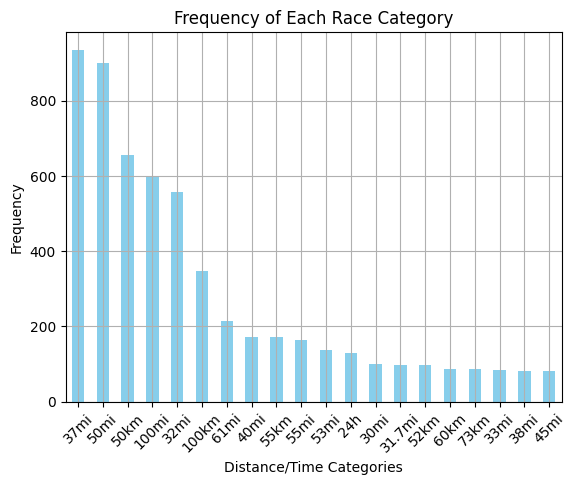

In [129]:
import matplotlib.pyplot as plt

value_counts = df['Distance/Time'].value_counts()
value_counts = value_counts.head(20)

# Plotting the bar chart
value_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Each Race Category')
plt.xlabel('Distance/Time Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotates the x labels to make them more readable
plt.grid(True)

# Show the plot
plt.show()

### Predictions

In [142]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

In [146]:
df['Runner ID'] = df['Runner ID'].astype(int)
merged_df['Runner ID'] = merged_df['Runner ID'].astype(int)

df_merged = pd.merge(merged_df, df, on='Runner ID', suffixes=('_bgr', '_results'))
df_merged.head()

,Counter,Surname_bgr,First name,Runner ID,Original name,Nat._bgr,M/F_bgr,YOB_bgr,Date of birth,Cat. internat.,...,Event,Date,Finishers,Rank,Finish Percentage,Distance/Time,Distance KM,Race Type,Time Seconds Finish,Distance Finish
0,1,Heaton,Alan,1462093,NaN,GBR,M,NaN,00.00.0000,NaN,...,Old County Tops Fell Race (GBR),21.05.1988,"42 (38 M, 4 F)",27,0.642857,37mi,59.0,trail race,35580.0,NaN
1,4,Beard,Eric,1048701,NaN,GBR,M,1931.0,00.00.0000,NaN,...,4th Balfe Cup 50 Mile Track Race (GBR),15.10.1966,"7 (7 M, 0 F)",7,1.000000,50mi,80.0,track,22483.0,NaN
2,4,Beard,Eric,1048701,NaN,GBR,M,1931.0,00.00.0000,NaN,...,4th 40 mile road race - Woodford to Southend (...,10.09.1966,"23 (23 M, 0 F)",17,0.739130,37mi,59.0,road race,17941.0,NaN
3,4,Beard,Eric,1048701,NaN,GBR,M,1931.0,00.00.0000,NaN,...,15th London to Brighton Road Race (GBR),25.09.1965,"36 (36 M, 0 F)",12,0.333333,84.5km,84.0,road race,22983.0,NaN
4,13,Weir,Dennis,113489,NaN,GBR,M,1938.0,25.03.1938,M85,...,4th Self-Transcendence 24 Hour Track Race Copt...,26.-27.10.1991,"29 (24 M, 5 F)",3,0.103448,24h,NaN,track,NaN,239.1


In [156]:
df_merged['avg_result'] = df_merged.groupby('Runner ID')['Finish Percentage'].transform('mean')

# Prepare data for training
X = df_merged[['avg_result','Distance KM','Time Seconds Finish']]  # features from results
y = df_merged['time seconds']  # target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')


ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [151]:
# Predicting race times for the actual race
actual_predictions = model.predict(df_merged[['avg_result']])

# Adding predictions back to the DataFrame
df_merged['predicted_time_seconds'] = actual_predictions

# Save the predictions
df_merged.to_csv('predicted_race_times.csv', index=False)

print("Predictions saved to 'predicted_race_times.csv'.")


Predictions saved to 'predicted_race_times.csv'.


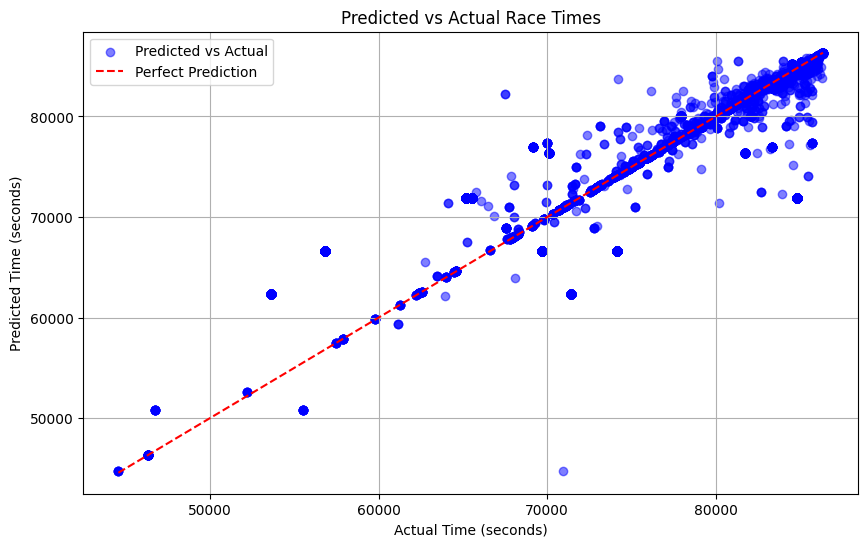

In [153]:

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df_merged['time seconds'], df_merged['predicted_time_seconds'], alpha=0.5, color='blue', label='Predicted vs Actual')
plt.xlabel('Actual Time (seconds)')
plt.ylabel('Predicted Time (seconds)')
plt.title('Predicted vs Actual Race Times')

# Plot a line of perfect prediction
max_time = max(df_merged['time seconds'].max(), df_merged['predicted_time_seconds'].max())
min_time = min(df_merged['time seconds'].min(), df_merged['predicted_time_seconds'].min())
plt.plot([min_time, max_time], [min_time, max_time], color='red', linestyle='--', label='Perfect Prediction')

plt.legend()
plt.grid(True)
plt.show()
